In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np

from dataset import MNIST_Moving
from encoder import Embedded_Encoder
from decoder import Embedded_Decoder
from conv_lstm import ConvLSTM
from model import Model
import utils

from torchsummary import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
train_set = MNIST_Moving(root='.data/mnist', train=True, download=True)
test_set = MNIST_Moving(root='.data/mnist', train=False, download=True)

batch_size = 1

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [5]:
input= next(iter(train_loader))
print("The shape of the input is ", input.shape)

vid_seq = input[0]
print("The shape of the video seq is", vid_seq.shape)



The shape of the input is  torch.Size([1, 20, 1, 64, 64])
The shape of the video seq is torch.Size([20, 1, 64, 64])


In [6]:
model = Model()

In [7]:
# test_tensor = torch.rand((20, 1, 64, 64)).to(device)
# model(test_tensor).shape

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [9]:
# loss_list = utils.train_epoch(model, train_loader, optimizer, criterion, 0, device)
train_loss, test_loss, loss_iter, epochs = utils.train_model(model, optimizer, scheduler, criterion, train_loader, test_loader, 20, device)

Epoch 1 Iter 9000: loss 1729.81604. : 100%|█| 9000/9000 [30:44<00:00,  4.88it/s]


Epoch 1/20
    Train loss: 2571.5756
    Valid loss: 2772.32843




Epoch 2 Iter 9000: loss 2152.87939. : 100%|█| 9000/9000 [30:36<00:00,  4.90it/s]


Epoch 2/20
    Train loss: 2324.02632
    Valid loss: 2650.92815




Epoch 3 Iter 9000: loss 2779.19897. : 100%|█| 9000/9000 [31:04<00:00,  4.83it/s]


Epoch 3/20
    Train loss: 2114.43031
    Valid loss: 2682.0657




Test loss: loss 2651.23:  19%|██▊            | 186/1000 [00:22<01:37,  8.39it/s]


KeyboardInterrupt: 

In [78]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def show(grid, name):
    fix, axs = plt.subplots()
    fix.set_size_inches(25,8)

    axs.imshow(grid.cpu().numpy().transpose(1,2,0))
    axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    fix.savefig(f"{name}.pdf", format="pdf", bbox_inches="tight")
    fix.show()
        
def visualize_results(model, test_loader, device):
    test_input = next(iter(test_loader)).squeeze(0).type(torch.FloatTensor).to(device)
    print(test_input.shape)
    
    out_ = model(test_input)
    out_ = out_.to(device)
    grid_gt = make_grid(test_input)
    grid_out = make_grid(out_)
    show(grid_gt, "gt")
    show(grid_out, "output")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 64, 64])


/tmp/ipykernel_7818/1330784375.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fix.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


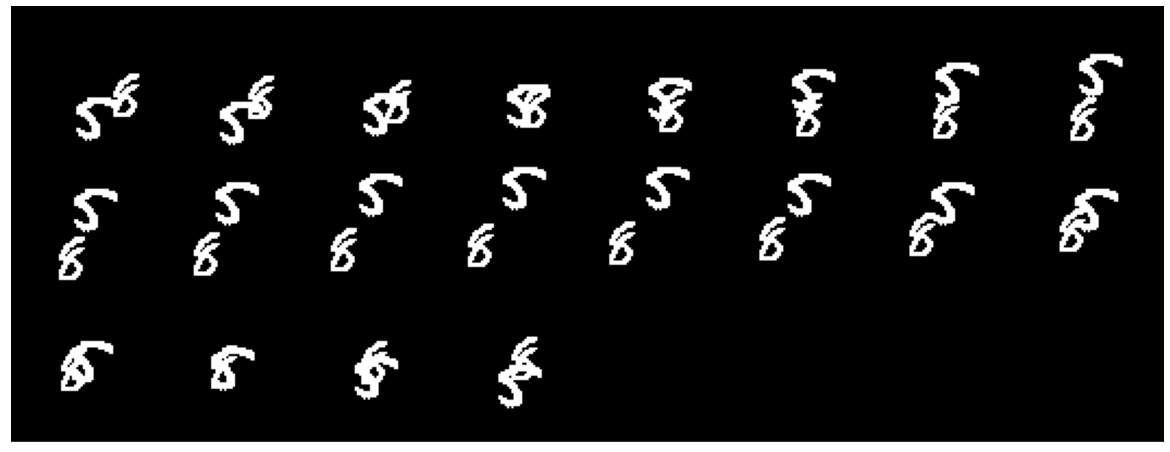

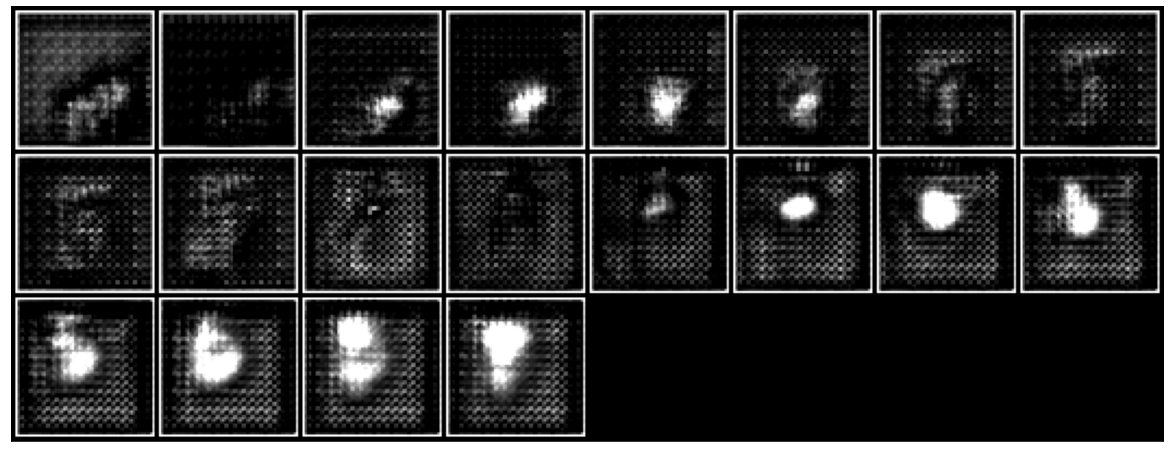

In [79]:
visualize_results(model, test_loader, device)